In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "/content/drive/My Drive/major"

/content/drive/My Drive/major


In [3]:
ls

'=0.6.2'                       mfcc_only.npy
'=1.0.0'                       Models/
'=.20'                         ngrok
 all_signal_data.npy           ngrok-stable-linux-amd64.zip
 all_signal_label.npy          noise/
 all_sig_waves.npy             None/
 augmented.csv                 requirement_new.txt
 augmented_data_unraveled.h5   songs/
 birdsong_metadata.csv         spare.ipynb
 combined_feat.npy             test/
 log/                          test_data_unraveled.h5
 mfcc+delta.npy                train/
 mfcc_label.npy


In [4]:


import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [6]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 12.3 GB  | Proc size: 890.1 MB
GPU RAM Free: 14858MB | Used: 221MB | Util   1% | Total 15079MB


In [7]:
from keras.layers import Conv2D,Reshape,MaxPooling2D
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense,Flatten
from keras.optimizers import Adam
from keras.layers import Dropout
#import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img,array_to_img,img_to_array
import pandas as pd

import gc
gc.collect()

Using TensorFlow backend.


0

In [8]:


Y = pd.DataFrame({'label': np.load('mfcc_label.npy',allow_pickle = True)})

j= Y.label.value_counts() > 40



k = j.index[j.values]
print(k)
print(len(k))
taken = []
for i in Y.label:
  if i in k:
    taken.append(True)
  else:
    taken.append(False)

#print("taken: ",taken)

X = np.load('mfcc+delta.npy')[taken]/255
Y = Y[taken]
print(len(X))
numclasses = len(k)

del j
#del Y
#del k
#del taken
gc.collect()
#print(len(X),len(Y))


Index(['arvensis', 'calandra', 'borin', 'megarhynchos', 'rustica',
       'philomelos', 'montanus', 'trochilus', 'cannabina', 'scirpaceus',
       'merula', 'coelebs', 'torquilla', 'stellata'],
      dtype='object')
14
1007


3

In [9]:
y = pd.get_dummies(Y).values
print(y.shape)
del Y


(1007, 14)


In [0]:
#plt.imshow()

In [0]:


train_x,test_x,train_y,test_y =  train_test_split(X,y,test_size = .1)
del X
del y

gc.collect()

img_size_flat = 32*128*4
img_shape = [32,128,4]
img_shape_full = [32,128,4]


In [12]:
print(train_x.shape,train_x.dtype)
print(train_y.shape,train_y.dtype)
print(numclasses)
print(train_y[2])


(906, 32, 128, 4) float64
(906, 14) uint8
14
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [0]:
def Model():
    model = Sequential()
    
    
    model.add(InputLayer(input_shape=img_shape_full))
    #print("shape outputted by the Input layer: ",model.output_shape)
    '''model.add(Reshape(target_shape = img_shape_full))
    #print("shape outputted by the reshape layer: ",model.output_shape)
    '''
    model.add(Conv2D(filters = 32,kernel_size = 3,activation = 'relu',strides = (2,2),padding = 'same',name = 'layer_conv1'))
    #print("shape outputted by the first convolutional layer: ",model.output_shape)
    model.add(MaxPooling2D(pool_size = (3,3),strides = (2,2)))
    #print("shape outputted by the MaxPooling Layer layer: ",model.output_shape)
    model.add(Conv2D(filters = 64,kernel_size = 5,activation = 'relu',strides = (2,1),padding = 'same',name = 'layer_conv2'))
    #print("shape outputted by the second Convolutional layer: ",model.output_shape)
    model.add(MaxPooling2D(pool_size = (3,3),strides = (2,2)))
    #print("shape outputted by the second Maxpooling layer: ",model.output_shape)
    '''
    
    model.add(Conv2D(filters = 64,kernel_size = 3,activation = 'relu'))
    #print("shape outputted by the convolutional layer: ",model.output_shape)
    model.add(MaxPooling2D(pool_size = (1,1), strides = (2,2)))
    '''
    batch_size = 16
    model.add(Dropout(rate = .5))
    #print("shape outputted by the Dropout layer: ",model.output_shape)
    model.add(Flatten())
    #print("shape outputted by the after flatten layer: ",model.output_shape)
    model.add(Dense(4096,activation = 'relu'))
    #print("shape outputted by the after Dense layer: ",model.output_shape)
    
    model.add(Dense(numclasses,activation = 'softmax'))
    
    optimizer = Adam(.001)
    
    model.compile(optimizer = optimizer,loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history = model.fit(x= train_x,y=train_y,epochs = 50,batch_size = batch_size,validation_split = .1)
    
    result = model.evaluate(x = test_x,y = test_y)
    for name,value in zip(model.metrics_names,result):
        print('{0}: {1}'.format(name,value))
    return model,history


In [14]:
m,history  = Model()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 815 samples, validate on 91 samples
Epoch 1/50
815/815 [==============================] - 3s 4ms/step - loss: 2.5136 - acc: 0.1853 - val_loss: 2.4762 - val_acc: 0.2198
Epoch 2/50
815/815 [==============================] - 0s 505us/step - loss: 2.2600 - acc: 0.2675 - val_loss: 2.2065 - val_acc: 0.3187
Epoch 3/50
815/815 [==============================] - 0s 473us/step - loss: 2.1240 - acc: 0.3018 - val_loss: 2.2131 - val_acc: 0.2418
Epoch 4/50
815/815 [==============================] - 0s 492us/step - loss: 1.9535 - acc: 0.3460 - val_loss: 1.9008 - val_acc: 0.3297
Epoch 5/50
815/815 [==============================] - 0s 493us/step - loss: 1.8292 - acc: 0.3791 - val_loss: 1.8238 - val_acc: 0.4396
Epoch 6/50
815/815 [==============================] 

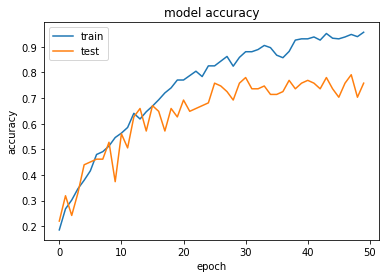

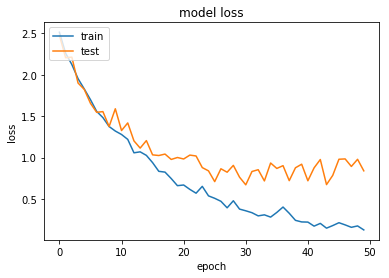

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [16]:
del train_x
del train_y
del test_x
del test_y
gc.collect()

5066

In [17]:
'''predicted = m.predict(test_x)
print(predicted.shape)
acc_count = np.argmax(predicted,1) == np.argmax(test_y,1)
total = len(test_y)
acc = np.sum(acc_count)
print("total: ",total)
print("Correctly_predicted: ",acc)
print(acc_count.any())
'''

'predicted = m.predict(test_x)\nprint(predicted.shape)\nacc_count = np.argmax(predicted,1) == np.argmax(test_y,1)\ntotal = len(test_y)\nacc = np.sum(acc_count)\nprint("total: ",total)\nprint("Correctly_predicted: ",acc)\nprint(acc_count.any())\n'